## Load data

In [2]:
# Load pickled data
import pickle

# Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Data summary

In [3]:
# Basic summary

n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


## Data Exploration

Plotting the histogram to show how many images per class are available in the training image set.
The next diagram shows example images for each class.

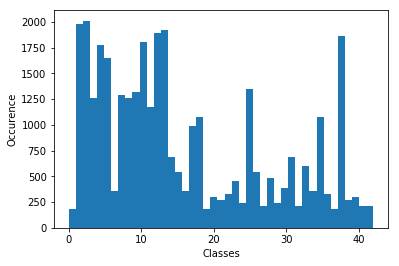

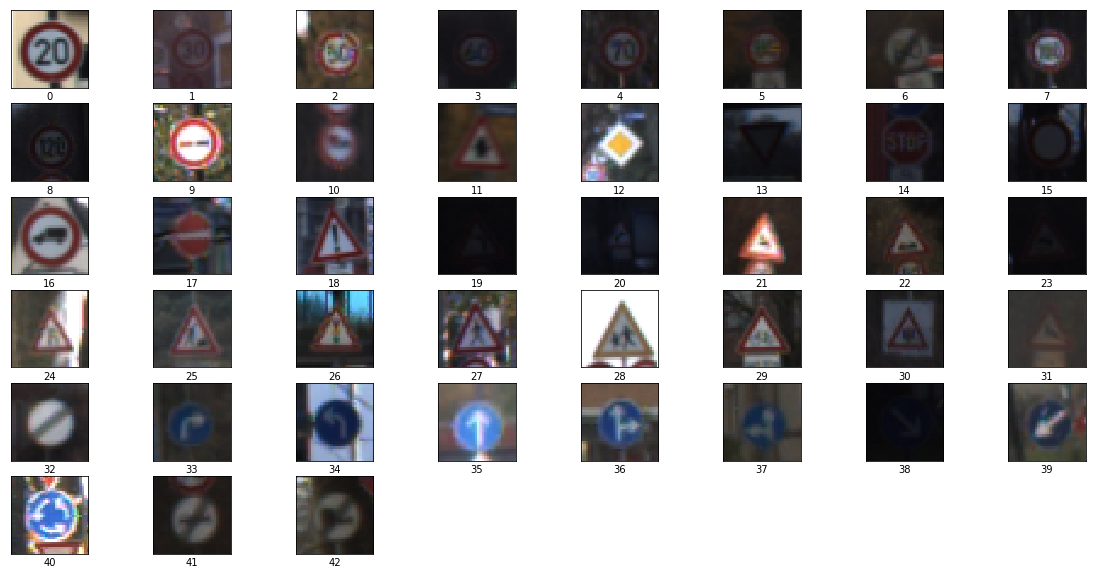

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Visualizations will be shown in the notebook.
%matplotlib inline
plt.hist(train['labels'], bins=n_classes)
plt.ylabel('Occurence');
plt.xlabel('Classes');
plt.show()

_, uniq_indexes = np.unique(y_train, return_index=True)
    
#Show one image for each class
plt.figure(figsize=(20,10))
for plot_i,i in enumerate(uniq_indexes):
    plt.subplot(6,8,plot_i+1)
    image = X_train[i]
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(plot_i)
plt.show()


## Normalize data
Here all input data will be normalized per channel using the min/max of the pixel value.

In [5]:
def normalize_images(images):
    for i in range(len(images)):
        images[i][...,0] = (images[i][...,0] - images[i][...,0].mean()) / images[i][...,0].std() - 0.5
        images[i][...,1] = (images[i][...,1] - images[i][...,1].mean()) / images[i][...,1].std() - 0.5
        images[i][...,2] = (images[i][...,2] - images[i][...,2].mean()) / images[i][...,2].std() - 0.5
    return images
    
X_train = X_train.astype(float)
X_valid = X_valid.astype(float)
X_test = X_test.astype(float)

X_train = normalize_images(X_train)
X_valid = normalize_images(X_valid)
X_test = normalize_images(X_test)

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Model Architecture

In [6]:
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 128

# Learning rate, l2 regularization factor, dropout keep probability
rate = 0.0005
beta = 0.02
keep = 0.7

from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1  = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1  = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W= tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b= tf.Variable(tf.zeros(16))
    conv2  = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2  = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2  = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0    = flatten(conv2)
    fc0    = tf.nn.dropout(fc0, keep_prob)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W  = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b  = tf.Variable(tf.zeros(120))
    fc1    = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43. (n_classes)
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

## Training the Model

In [11]:
# Define training operations
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32, (None))

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
regularizer = tf.nn.l2_loss(x)
loss = tf.reduce_mean(loss_operation + beta * regularizer)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [7]:
# Train
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    training_history = []
    validation_history = []
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: keep})
            
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        training_history.append(training_accuracy)
        validation_history.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Training...

EPOCH 1 ...
Training Accuracy = 0.622
Validation Accuracy = 0.575

EPOCH 2 ...
Training Accuracy = 0.830
Validation Accuracy = 0.773

EPOCH 3 ...
Training Accuracy = 0.911
Validation Accuracy = 0.867

EPOCH 4 ...
Training Accuracy = 0.936
Validation Accuracy = 0.902

EPOCH 5 ...
Training Accuracy = 0.954
Validation Accuracy = 0.916

EPOCH 6 ...
Training Accuracy = 0.963
Validation Accuracy = 0.931

EPOCH 7 ...
Training Accuracy = 0.968
Validation Accuracy = 0.936

EPOCH 8 ...
Training Accuracy = 0.975
Validation Accuracy = 0.942

EPOCH 9 ...
Training Accuracy = 0.978
Validation Accuracy = 0.949

EPOCH 10 ...
Training Accuracy = 0.979
Validation Accuracy = 0.950

EPOCH 11 ...
Training Accuracy = 0.984
Validation Accuracy = 0.957

EPOCH 12 ...
Training Accuracy = 0.986
Validation Accuracy = 0.957

EPOCH 13 ...
Training Accuracy = 0.987
Validation Accuracy = 0.958

EPOCH 14 ...
Training Accuracy = 0.988
Validation Accuracy = 0.960

EPOCH 15 ...
Training Accuracy = 0.990
Valid

Below the plot shows the training vs the validation progress on the learning:

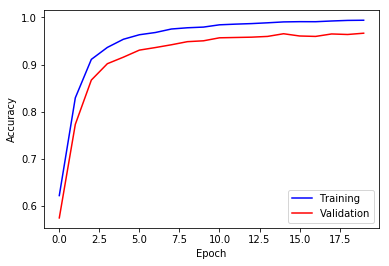

In [8]:
plt.plot(training_history, color='b', label='Training')
plt.plot(validation_history, color='r', label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

---
## Test a Model on New Images


INFO:tensorflow:Restoring parameters from ./lenet


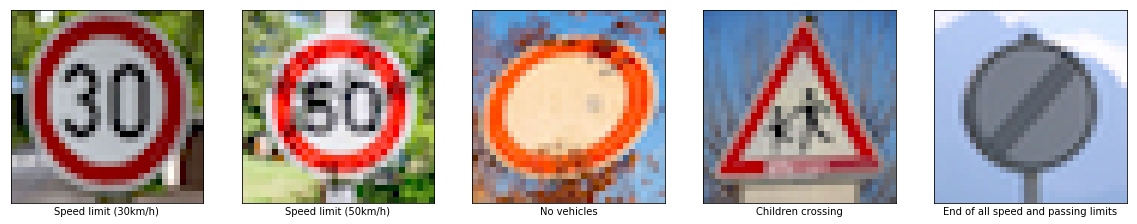

Top 5 predictions:
Top 1 : Speed limit (30km/h) =>  " Speed limit (30km/h) " @ 0.99998
Top 2 : Speed limit (30km/h) =>  " Speed limit (50km/h) " @ 0.00001
Top 3 : Speed limit (30km/h) =>  " Speed limit (20km/h) " @ 0.00001
Top 4 : Speed limit (30km/h) =>  " Speed limit (70km/h) " @ 0.00000
Top 5 : Speed limit (30km/h) =>  " End of speed limit (80km/h) " @ 0.00000
Top 1 : Speed limit (50km/h) =>  " Speed limit (50km/h) " @ 0.96336
Top 2 : Speed limit (50km/h) =>  " Speed limit (80km/h) " @ 0.03539
Top 3 : Speed limit (50km/h) =>  " Speed limit (60km/h) " @ 0.00125
Top 4 : Speed limit (50km/h) =>  " Speed limit (30km/h) " @ 0.00000
Top 5 : Speed limit (50km/h) =>  " Speed limit (100km/h) " @ 0.00000
Top 1 : No vehicles =>  " No vehicles " @ 0.99989
Top 2 : No vehicles =>  " Speed limit (50km/h) " @ 0.00007
Top 3 : No vehicles =>  " Yield " @ 0.00002
Top 4 : No vehicles =>  " Speed limit (30km/h) " @ 0.00001
Top 5 : No vehicles =>  " Speed limit (70km/h) " @ 0.00001
Top 1 : Children cross

In [15]:
from scipy import misc
import pandas as pd

signnames = pd.read_csv('signnames.csv')
sname = signnames[signnames['ClassId'] == 1]['SignName']
#print(signnames)


images = []
X_new = []
y_new = [1,2,15,28,32]
image_names = ['data/c1.jpg', 'data/c2.jpg', 'data/c15.jpg', 'data/c28.jpg', 'data/c32.jpg']

# Read images
for name in image_names:
    image = misc.imread(name)
    images.append(image)
    X_new.append(image)
    

# Normalize
X_new = np.array(X_new).astype(float)
X_new = normalize_images(X_new)

top5 = [] # Top 5 softmax predictions

# Classify
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax_op = tf.nn.softmax(logits)
    for i in range(len(X_new)):
        softmax_p = sess.run(softmax_op, feed_dict={x: np.array([X_new[i]]), y: np.array([y_new[i]]), keep_prob: 1.0})
        top5_values, top5_indices = sess.run(tf.nn.top_k(tf.constant(softmax_p), k=5))
        top5.append([top5_values, top5_indices])

# Display images
figure = plt.figure(figsize=(20,5))
for plot_i,i in enumerate(range(len(images))):
    plt.subplot(1,len(images),plot_i+1)
    image = images[i]
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    class_id = top5[i][1][0][0]
    sign_name = signnames[signnames['ClassId'] == class_id]['SignName'].tolist()[0]
    plt.xlabel(sign_name)
plt.show()

print("Top 5 predictions:")
for each_image in range(len(top5)):
    class_ids = top5[each_image][1][0]
    class_scores = top5[each_image][0][0]
    class_names = [signnames[signnames['ClassId'] == class_id]['SignName'].tolist()[0] for class_id in class_ids]
    predicted = list(zip(class_scores,class_names))
    true_sign_name = signnames[signnames['ClassId'] == y_new[each_image]]['SignName'].tolist()[0]
    for topx,i in enumerate(range(len(predicted))):
        print("Top", topx+1, ":", true_sign_name, "=>  \"", predicted[i][1], "\" @ %.5f" % (predicted[i][0]))
